# Assignment 3 - Inverse Problems 2023 - Emilie Jessen

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import linalg
import scipy.stats

In [2]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

axes = {'facecolor': 'ghostwhite',
        'grid': 'True'}
mpl.rc('axes', **axes)

In [3]:
# Loading the data
data = np.loadtxt("mars_soil.txt")
x = np.array(data[:,0])
y = np.array(data[:,1])
yerr = np.ones(len(x)) * 0.03*10**4

In [4]:
# Inspecting the data to make initial guess on model parameters 

N_peaks = 20

# Areas for Gaussian fit 
A0 = np.array([-500, -1500, -1200, -300, -600, -900, -1300, -350, -950, -500, \
      -500, -1100, -550, -1300, -1050, -700, -500, -1400, -1500, -600])

# Areas for Lorentzian fit
A0_L = np.array([-500, -1500, -1500, -400, -850, -1150, -1350, -450, -1300, -500, \
      -500, -1350, -550, -1400, -1050, -850, -350, -1450, -1500, -600]) * 2.6

# Widths 
c0 = np.array([0.15, 0.15, 0.12, 0.1, 0.1, 0.12, 0.14, 0.1, 0.11, 0.15, \
      0.15, 0.12, 0.14, 0.13, 0.13, 0.11, 0.15, 0.14, 0.14, 0.15])

# Frequencies 
f0 = np.array([-10.5, -8.8, -7.65, -6.95, -6.45, -5.55, -4.35,-3.65, -3.15, \
      -1.7, 1.7, 3.1, 3.6, 4.25, 5.45, 6.35, 6.85, 7.55, 8.75, 10.5])


# Collecting the initial guess in a vector - Gaussian 
m0 = np.zeros(3*N_peaks)

for i in range(N_peaks):
    m0[3*i :3*i + 3] = [A0[i], f0[i], c0[i]]


# Collecting the initial guess in a vector - Lorentzian
m0_L = np.zeros(3*N_peaks)

for i in range(N_peaks):
    m0_L[3*i :3*i + 3] = [A0_L[i], f0[i], c0[i]]

In [5]:
def fit_data(x, m, peak_shape='Gauss'):
    """Function that takes the model parameters and returns the fit to the data given the shape of the peaks."""

    A = m[::3]
    f = m[1::3]
    c = m[2::3]

    if peak_shape == 'Gauss':

        fit = np.zeros(len(x)) + 12550

        for i in range(N_peaks):
            fit += A[i] * scipy.stats.norm.pdf(x, loc=f[i], scale=c[i])

    else: 

        fit = np.zeros(len(x)) + 12660

        for i in range(N_peaks):
            fit += A[i] * c[i]**2 / ((x - f[i])**2 + c[i]**2)

    return fit

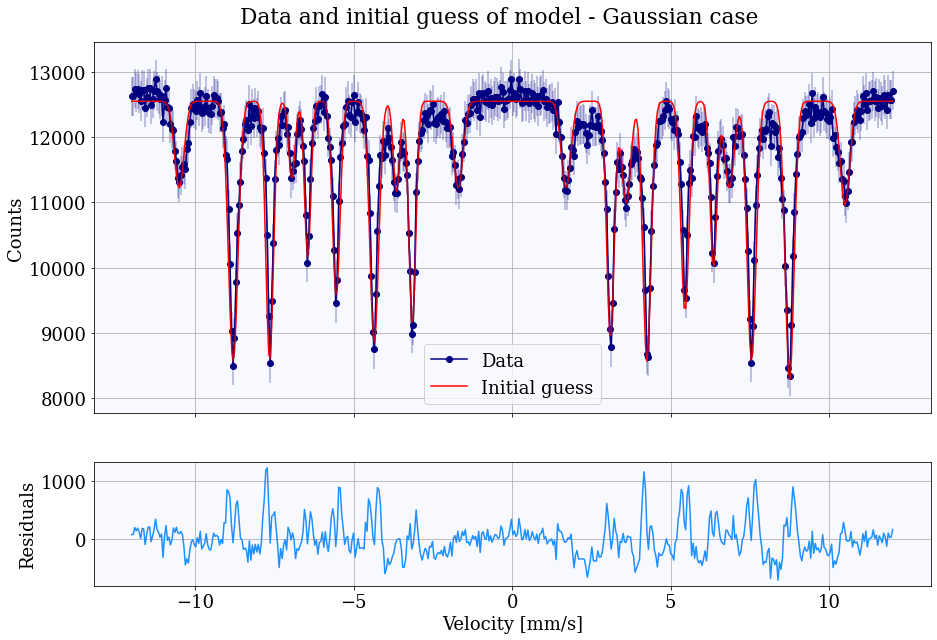

In [32]:
init_gauss = fit_data(x, m0, 'Gauss')

# Visualising the data and initial estimate of the model - Gaussian case 

fig, ax = plt.subplots(nrows=2, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
title = fig.suptitle('Data and initial guess of model - Gaussian case', y=0.93)
ax[0].plot(x, y, '-o', label='Data', color='navy')
ax[0].plot(x, init_gauss, label='Initial guess', color='red')
ax[0].errorbar(x, y, yerr=yerr, color='navy', alpha=0.3)
ax[0].set(ylabel='Counts')

ax[1].plot(x, y - init_gauss, '-', color='dodgerblue')
ax[1].set(xlabel='Velocity [mm/s]', 
       ylabel='Residuals')

ax[0].legend();

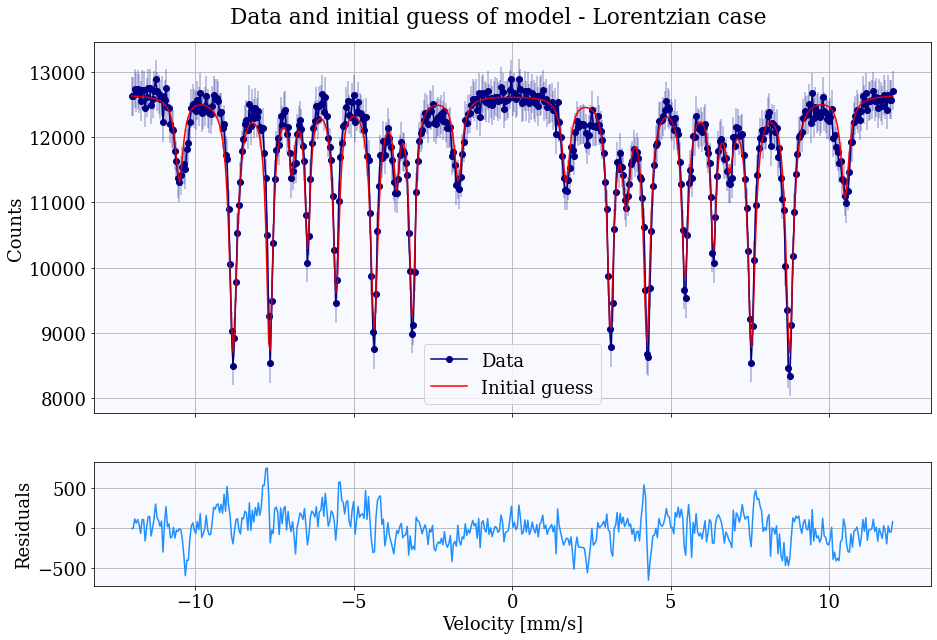

In [33]:
init_lorentz = fit_data(x, m0_L, 'Lorentz')

# Visualising the data and initial estimate of the model - Lorentzian case 

fig, ax = plt.subplots(nrows=2, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
title = fig.suptitle('Data and initial guess of model - Lorentzian case', y=0.93)
ax[0].plot(x, y, '-o', label='Data', color='navy')
ax[0].plot(x, init_lorentz, label='Initial guess', color='red')
ax[0].errorbar(x, y, yerr=yerr, color='navy', alpha=0.3)
ax[0].set(ylabel='Counts')

ax[1].plot(x, y - init_lorentz, '-', color='dodgerblue')
ax[1].set(xlabel='Velocity [mm/s]', 
       ylabel='Residuals')

ax[0].legend();


1. Using the forward relation: $\mathbf{d} = g(\mathbf{m})$ to obtain the analytical formulas for the derivatives. In the code below the expressions for the Gaussian case are implemented. 

$$  \frac{\partial{g_i}}{\partial{A_p}} = \frac{1}{\sqrt{2\pi}c_p} \exp{ \left[-\frac{(z_i - f_p)^2}{2c_p^2} \right]}$$


$$  \frac{\partial{g_i}}{\partial{f_p}} = \frac{A_p}{\sqrt{2\pi}c_p} \exp{ \left[-\frac{(z_i - f_p)^2}{2c_p^2} \right]} \cdot \frac{(z_i - f_p)}{c_p^2}$$

$$  \frac{\partial{g_i}}{\partial{c_p}} = \frac{A_p}{\sqrt{2\pi}} \left( \frac{-1}{c_p^2} \exp{ \left[-\frac{(z_i - f_p)^2}{2c_p^2} \right]} + \frac{(z_i - f_p)^2}{c_p^4} \exp{ \left[-\frac{(z_i - f_p)^2}{2c_p^2} \right]} \right)$$

In [9]:
def dGauss_dA(x, A, c, f): 
    const = 1 / (np.sqrt(2 * np.pi) * c)
    exp = np.exp(-(x - f)**2 / (2 * c**2))
    return  const * exp


def dGauss_df(x, A, c, f):
    const = A / (np.sqrt(2 * np.pi) * c)
    exp = np.exp(-(x - f)**2 / (2 * c**2))
    return  const * exp * (x - f) / c**2


def dGauss_dc(x, A, c, f):
    const1 = -A / (np.sqrt(2 * np.pi) * c**2)
    const2 = A / (np.sqrt(2 * np.pi) * c)
    exp = np.exp(-(x - f)**2 / (2 * c**2))
    return const1 * exp + const2 * exp * (x - f)**2 / c**3

2. In the code below the analytical formulas for the derivatives for the Lorentzian case are implemented. 

$$  \frac{\partial{g_i}}{\partial{A_p}} = \frac{c_p^2}{(z_i - f_p)^2 + c_p^2} $$

$$  \frac{\partial{g_i}}{\partial{f_p}} = \frac{A_p c_p^2}{((z_i - f_p)^2 + c_p^2)^2} \cdot 2(z_i - f_p) $$


$$  \frac{\partial{g_i}}{\partial{c_p}} = 2 A_p c_p \left( \frac{1}{(z_i - f_p)^2 + c_p^2} - \frac{c_p^2}{((z_i - f_p)^2 + c_p^2)^2}  \right)$$

In [10]:
def dLorentz_dA(x, A, c, f):
    return c**2 / ((x - f)**2 + c**2)

def dLorentz_df(x, A, c, f):
    nom = (x - f)**2 + c**2
    return A * c**2 / nom**2 * (2 * (x - f))

def dLorentz_dc(x, A, c, f):
    nom = ((x - f)**2 + c**2)
    return 2 * A * c / nom - 2 * A * c**3 / nom**2

3. In the code below a function is implemented to evaluate the derivatives in the solution $\mathbf{m}$ and stored in the G-matrix for the Gaussian and Lorentzian case. The evaluation is shown for the initial estimate on the model parameters.

In [11]:
def G_matrix(x, m, peak_shape='Gauss'): 
    """Function that returns the G matrix for the given model parameters m and the shape of the peaks."""

    A = m[::3]
    f = m[1::3]
    c = m[2::3]

    G = np.zeros((len(m), len(x)))

    if peak_shape == 'Gauss':

        for i in range(len(x)):
            G[::3, i] = dGauss_dA(x[i], A, c, f)
            G[1::3, i] = dGauss_df(x[i], A, c, f)
            G[2::3, i] = dGauss_dc(x[i], A, c, f)

    else:
            
        for i in range(len(x)):
            G[::3, i] = dLorentz_dA(x[i], A, c, f)
            G[1::3, i] = dLorentz_df(x[i], A, c, f)
            G[2::3, i] = dLorentz_dc(x[i], A, c, f)

    return G.T

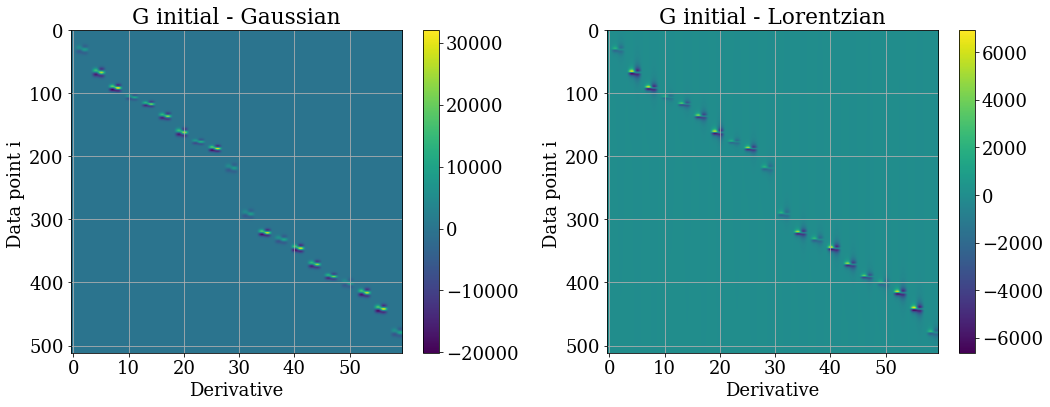

In [38]:
# Visualising the G matrix for the initial estimate of the model - Gaussian case

G0_Gauss = G_matrix(x, m0, 'Gauss')
G0_Lorentz = G_matrix(x, m0, 'Lorentz')

fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
im0 = ax[0].imshow(G0_Gauss, aspect='auto')
fig.colorbar(im0, ax=ax[0])
ax[0].set(xlabel='Derivative', 
       ylabel='Data point i ',
       title='G initial - Gaussian')

im1 = ax[1].imshow(G0_Lorentz, aspect='auto')
fig.colorbar(im1, ax=ax[1])
ax[1].set(xlabel='Derivative', 
       ylabel='Data point i ',
       title='G initial - Lorentzian')
fig.tight_layout();

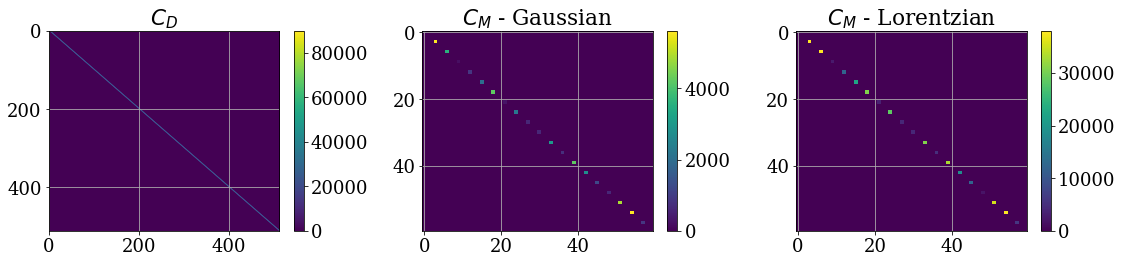

In [41]:
# Data covariance matrix - assuming uncorrelated data
C_D = np.diag(yerr**2)


# Estimating correlation between parameters
corr_val = 1e-5
corr_M = np.array([np.array([0, 1, 0]), 
                   np.array([1, 0, 0]), 
                   np.array([0, 0, 0])])
corr = np.kron(np.eye(20), corr_M)


# Esimating the uncertainties in the parameters as percentages of the initial guess
sigma_A_Gauss = A0 * 0.05   
sigma_A_Lorentz = A0_L * 0.05    
sigma_f = f0 * 0.02
sigma_c = c0 * 0.03

C_M_Gauss = np.diag(np.array([sigma_A_Gauss**2, sigma_f**2, sigma_c**2]).reshape(3,20).T.flatten()) + corr
C_M_Lorentz = np.diag(np.array([sigma_A_Lorentz**2, sigma_f**2, sigma_c**2]).reshape(3,20).T.flatten()) + corr


# Visaualising the covariance matrices
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))

im1 = ax[0].imshow(C_D, aspect='auto')
ax[0].set(title=r'$C_D$')

im2 = ax[1].imshow(C_M_Gauss, aspect='auto')
ax[1].set(title=r'$C_M$ - Gaussian')

im3 = ax[2].imshow(C_M_Lorentz, aspect='auto')
ax[2].set(title=r'$C_M$ - Lorentzian')

fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
fig.colorbar(im3, ax=ax[2])
fig.tight_layout();

In [55]:
def steepest_descent(x, y, m0, epsilon, max_iter, peak_shape='Gauss'):
    
    m = m0.copy()
    resi = []

    if peak_shape == 'Gauss':
        C_M = C_M_Gauss
    else:
        C_M = C_M_Lorentz

    for _ in range(max_iter):
        G = G_matrix(x, m, peak_shape)
        g = fit_data(x, m, peak_shape)
        
        m_new = m - epsilon * (C_M @ G.T @ np.linalg.inv(C_D) @ (g - y) + (m - m0))
        m = m_new.copy()
        resi.append(np.sum((y - g)**2))
        
    return m, resi

In [66]:
m_best_G, fit_resi_G = steepest_descent(x, y, m0, 1e-4, 5000, 'Gauss')

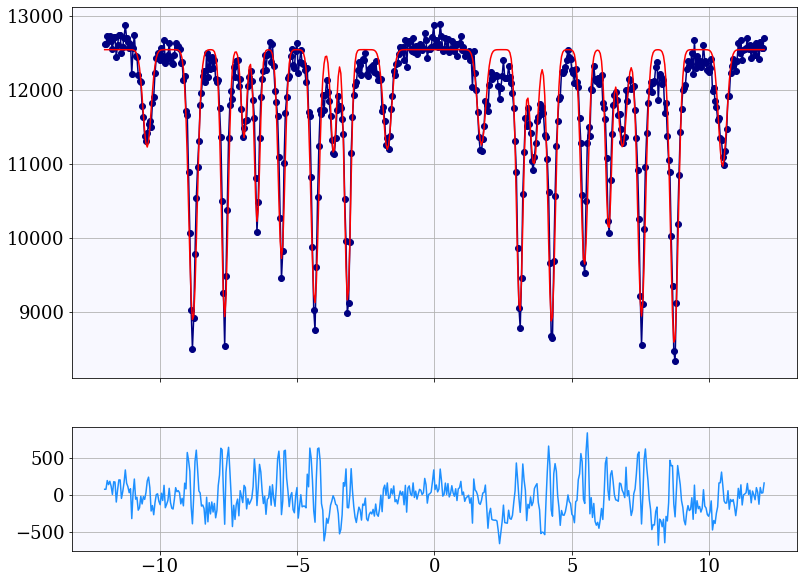

In [67]:
fit_G = fit_data(x, m_best_G, 'Gauss')
resi_G = y - fit_G  

fig, ax = plt.subplots(nrows=2, figsize=(13, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
ax[0].plot(x, y, '-o', label='Data', color='navy')
ax[0].plot(x, fit_G, label='Best fit', color='red')

ax[1].plot(x, resi_G, '-', color='dodgerblue');

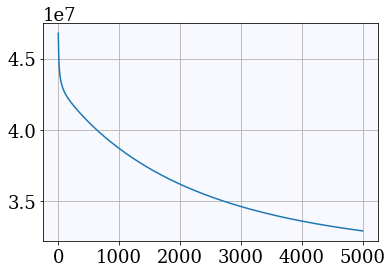

In [68]:
plt.plot(fit_resi_G)

In [18]:
m_best_L = steepest_descent(x, y, m0_L, 0.0001, 1000, 'Lorentz')

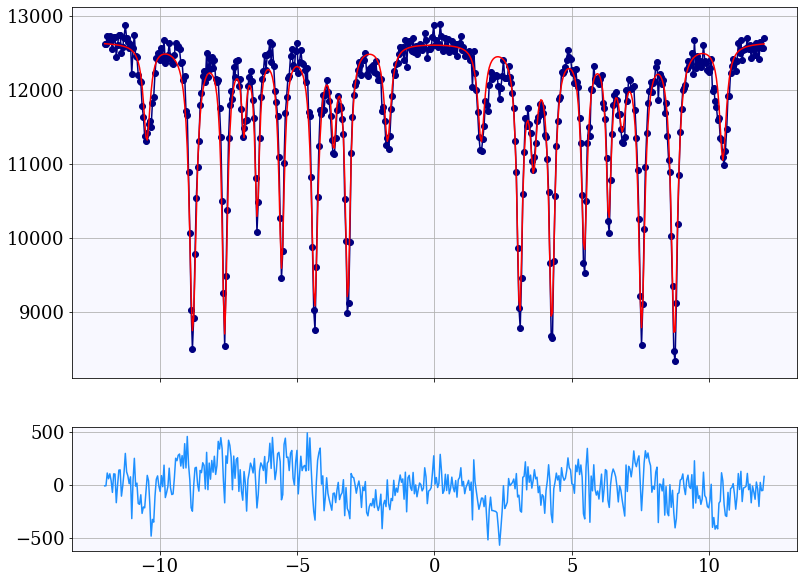

In [19]:
fit_L = fit_data(x, m_best_L, 'Lorentz')
resi_L = y - fit_data(x, m_best_L, 'Lorentz')

fig, ax = plt.subplots(nrows=2, figsize=(13, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
ax[0].plot(x, y, '-o', label='Data', color='navy')
ax[0].plot(x, fit_L, label='Best fit', color='red')
ax[1].plot(x, resi_L, '-', color='dodgerblue')

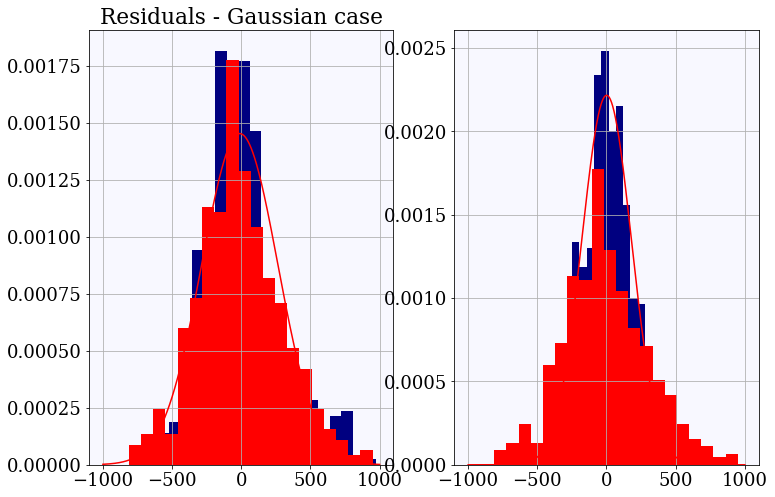

In [29]:
axis = np.linspace(-1000, 1000, 1000)
noise_dist = np.random.normal(0, yerr[0], len(y))

mean_G = np.mean(resi_G)    
std_G = np.std(resi_G)

mean_L = np.mean(resi_L)
std_L = np.std(resi_L)

fig, ax = plt.subplots(ncols=2, figsize=(12, 8))
ax[0].hist(resi_G, bins=20, color='navy', density=True)
ax[0].hist(noise_dist, bins=20, color='red', density=True)
ax[0].plot(axis, scipy.stats.norm.pdf(axis, mean_G, std_G), color='red')
ax[0].set(title='Residuals - Gaussian case')

ax[1].hist(resi_L, bins=20, color='navy', density=True)
ax[1].hist(noise_dist, bins=20, color='red', density=True)

ax[1].plot(axis, scipy.stats.norm.pdf(axis, mean_L, std_L), color='red');

In [30]:
AD_Gauss = scipy.stats.anderson_ksamp([resi_G, noise_dist])
AD_Lorentz = scipy.stats.anderson_ksamp([resi_L, noise_dist])

KS_Gauss = scipy.stats.ks_2samp(resi_G, noise_dist)
KS_Lorentz = scipy.stats.ks_2samp(resi_L, noise_dist)

<ipython-input-30-1b708b2e3208>:2: UserWarning: p-value floored: true value smaller than 0.001
  AD_Lorentz = scipy.stats.anderson_ksamp([resi_L, noise_dist])


In [31]:
print('P-value for Anderson-Darling test - Gaussian case: ', AD_Gauss[-1])
print('P-value for Kolmogorov-Smirnov test - Gaussian case: ', KS_Gauss.pvalue)

print('P-value for Anderson-Darling test - Lorentzian case: ', AD_Lorentz[-1])
print('P-value for Kolmogorov-Smirnov test - Lorentzian case: ', KS_Lorentz.pvalue)

P-value for Anderson-Darling test - Gaussian case:  0.05137357438157595
P-value for Kolmogorov-Smirnov test - Gaussian case:  0.02669818586016339
P-value for Anderson-Darling test - Lorentzian case:  0.001
P-value for Kolmogorov-Smirnov test - Lorentzian case:  0.00023499411062125904
